## bayesian model pmod

In [1]:
import os
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
import nilearn.plotting

201012-15:35:23,110 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


In [ ]:
# Meyniel toolbox
# !git clone https://github.com/florentmeyniel/TransitionProbModel.git

In [2]:
# !ls /model

In [2]:
import sys, os
sys.path.append('/model')
from MarkovModel_Python import IdealObserver as IO
from MarkovModel_Python import GenerateSequence as sg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings

### set up

In [3]:
experiment_dir = '/output'
output_dir = 'prob_pmod'
working_dir = 'workingdir'
TR = 2.

### sepcify nodes

In [4]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

### helper functions dev

In [5]:
alltrialinfo = pd.read_csv('/tsl_data/data/fmri_behavioural.csv')
alltrialinfo.head()

,subject,session,trial,seq,rt,gen_p1g2,gen_p2g1,prob_pxl,prob_obs,obs_p1g2,obs_p2g1,obs_p1g1,obs_p2g2,obs_p1,obs_p2,obs_p,runtime
0,6,1,1,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.60
1,6,1,2,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.10
2,6,1,3,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.60
3,6,1,4,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.05
4,6,1,5,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.60


In [8]:
def construct_sj(trialinfo, subject_id, run_num, cond_name=None):
    # construct df
    df_sj = trialinfo[(trialinfo['subject']==int(subject_id)) & (trialinfo['session']==int(run_num))]
    sj_info = pd.DataFrame()
    sj_info['onset'] = df_sj['runtime']
    sj_info['duration'] = 0.
    sj_info['weight'] = 1.
    trial_type = df_sj['seq'].replace({1:'Low', 2:'High'})
    sj_info['trial_type'] = trial_type
    if cond_name:
        sj_info_cond = sj_info[sj_info['trial_type']==cond_name]
    else:
        sj_info_cond = sj_info
    return sj_info_cond

In [9]:
construct_sj(alltrialinfo, '06', '1')

,onset,duration,weight,trial_type
0,1.60,0.0,1.0,High
1,3.10,0.0,1.0,High
2,4.60,0.0,1.0,High
3,6.05,0.0,1.0,High
4,7.60,0.0,1.0,High
...,...,...,...,...
255,469.05,0.0,1.0,High
256,470.45,0.0,1.0,Low
257,471.85,0.0,1.0,High
258,473.40,0.0,1.0,Low


In [6]:
# preparing data for modelling
def unpack(df):
    """extract sequence and ratings"""
    seq = df['seq'].values - 1 # convert to toolbox format 1->0 low, 2->1 high
    rate_idx = {}
    rate_idx['p1g1'] = df['obs_p1g1'].notnull()
    rate_idx['p1g2'] = df['obs_p1g2'].notnull()
    rate_idx['p2g2'] = df['obs_p2g2'].notnull()
    rate_idx['p2g1'] = df['obs_p2g1'].notnull()
    rate_obs = df['obs_p']
    return seq, rate_idx, rate_obs

def fit(df, model='fixed', order=0, options={'decay':5}):
    """fit given sequence"""
    seq, rate_idx, rate_p = unpack(df)
    model_p = np.empty(seq.shape)
    model_p.fill(np.nan)
    gen_p = np.empty(seq.shape).fill(np.nan)
    out = IO.IdealObserver(seq, model, order=order, 
                           options=options)
    if order == 0:
        p0 = out[(0,)]['mean'] # equivalent to 1
        p1 = out[(1,)]['mean'] # equivalent to 2
        # recording output
        model_p[rate_idx['p1g2']] = p0[rate_idx['p1g2']]
        model_p[rate_idx['p2g1']] = p1[rate_idx['p2g1']]
        model_full = pd.DataFrame({'p0':p0, 'p1':p1, 'surprise':out['surprise']}, index=None)
    elif order == 1:
        p01 = out[(1,0)]['mean'] # p(0|1)
        p10 = out[(0,1)]['mean'] # p(1|0)
        p11 = out[(1,1)]['mean'] # p(1|1)
        p00 = out[(0,0)]['mean'] # p(0|0)
        # record output
        # print(p01[-10:])
        # print(p10[-10:])
        model_p[rate_idx['p1g2']] = p01[rate_idx['p1g2']]
        model_p[rate_idx['p2g1']] = p10[rate_idx['p2g1']]
        model_full = pd.DataFrame({'p01':p01, 'p10':p10, 'surprise':out['surprise']}, index=None)

    return model_p, rate_p, model_full

def model_df(df, model='fixed', order=0, options={'decay':5}, dropna=True):
    """create hierarchical model df"""
    model_p, rate_p, model_full = fit(df, model, order, options)
    df['model_p'] = model_p
    df['rate_p'] = rate_p
    df_out = pd.concat([df.reset_index(), model_full], axis=1)
    if dropna:
        df_out.dropna(subset=['model_p'], inplace=True)
    return df_out

def model_subject(trialinfo, subject_id, run_num, model, order, options, dropna=False):
    """apply model and extract subject/run"""
    dfm = model_df(trialinfo, model=model, order=int(order), options=options, dropna=dropna)
    df_sj = dfm[(dfm['subject']==int(subject_id)) & (dfm['session']==int(run_num))]
    return df_sj

In [11]:
dfmm = model_subject(alltrialinfo, subject_id='06', run_num=1, 
              model='hmm', order=0, options={'p_c':0.05, 'resol':20}, 
              dropna=False)

In [19]:
# dfmm['p1'].values.tolist()

### specify GLM

In [5]:
def subjectinfo(subject_id):

    import pandas as pd
    import numpy as np
    import sys, os
    sys.path.append('/model')
    from MarkovModel_Python import IdealObserver as IO
    from MarkovModel_Python import GenerateSequence as sg
    from nipype.interfaces.base import Bunch
    
    def construct_sj(trialinfo, subject_id, run_num, cond_name=None):
        # construct df
        df_sj = trialinfo[(trialinfo['subject']==int(subject_id)) & (trialinfo['session']==int(run_num))]
        sj_info = pd.DataFrame()
        sj_info['onset'] = df_sj['runtime']
        sj_info['duration'] = 0.
        sj_info['weight'] = 1.
        trial_type = df_sj['seq'].replace({1:'Low', 2:'High'})
        sj_info['trial_type'] = trial_type
        if cond_name:
            sj_info_cond = sj_info[sj_info['trial_type']==cond_name]
        else:
            sj_info_cond = sj_info
        return sj_info_cond

    def select_confounds(subject_id, run_num, conf_names):
        """select confounds for regressor"""
        confounds_dir = f'/data/sub-%02d/func/' % int(subject_id)
        confounds_file = confounds_dir+f'sub-%02d_task-tsl_run-%d_desc-confounds_regressors.tsv' % (int(subject_id), int(run_num))
        conf_df = pd.read_csv(confounds_file, sep='\t')
        conf_select = conf_df[conf_names].loc[4:].fillna(0)
        conf_select_list = [conf_select[col].values.tolist() for col in conf_select] # ignore first 4 dummy scans
        return conf_select_list
    
    # preparing data for modelling
    def unpack(df):
        """extract sequence and ratings"""
        seq = df['seq'].values - 1 # convert to toolbox format 1->0 low, 2->1 high
        rate_idx = {}
        rate_idx['p1g1'] = df['obs_p1g1'].notnull()
        rate_idx['p1g2'] = df['obs_p1g2'].notnull()
        rate_idx['p2g2'] = df['obs_p2g2'].notnull()
        rate_idx['p2g1'] = df['obs_p2g1'].notnull()
        rate_obs = df['obs_p']
        return seq, rate_idx, rate_obs

    def fit(df, model='fixed', order=0, options={'decay':5}):
        """fit given sequence"""
        seq, rate_idx, rate_p = unpack(df)
        model_p = np.empty(seq.shape)
        model_p.fill(np.nan)
        gen_p = np.empty(seq.shape).fill(np.nan)
        out = IO.IdealObserver(seq, model, order=order, 
                               options=options)
        if order == 0:
            p0 = out[(0,)]['mean'] # equivalent to 1
            p1 = out[(1,)]['mean'] # equivalent to 2
            # recording output
            model_p[rate_idx['p1g2']] = p0[rate_idx['p1g2']]
            model_p[rate_idx['p2g1']] = p1[rate_idx['p2g1']]
            model_full = pd.DataFrame({'p0':p0, 'p1':p1, 'surprise':out['surprise']}, index=None)
        elif order == 1:
            p01 = out[(1,0)]['mean'] # p(0|1)
            p10 = out[(0,1)]['mean'] # p(1|0)
            p11 = out[(1,1)]['mean'] # p(1|1)
            p00 = out[(0,0)]['mean'] # p(0|0)
            # record output
            # print(p01[-10:])
            # print(p10[-10:])
            model_p[rate_idx['p1g2']] = p01[rate_idx['p1g2']]
            model_p[rate_idx['p2g1']] = p10[rate_idx['p2g1']]
            model_full = pd.DataFrame({'p01':p01, 'p10':p10, 'surprise':out['surprise']}, index=None)

        return model_p, rate_p, model_full

    def model_df(df, model='fixed', order=0, options={'decay':5}, dropna=True):
        """create hierarchical model df"""
        model_p, rate_p, model_full = fit(df, model, order, options)
        df['model_p'] = model_p
        df['rate_p'] = rate_p
        df_out = pd.concat([df.reset_index(), model_full], axis=1)
        if dropna:
            df_out.dropna(subset=['model_p'], inplace=True)
        return df_out

    def model_subject(trialinfo, subject_id, run_num, model, order, options, dropna=False):
        """apply model and extract subject/run"""
        dfm = model_df(trialinfo, model=model, order=int(order), options=options, dropna=dropna)
        df_sj = dfm[(dfm['subject']==int(subject_id)) & (dfm['session']==int(run_num))]
        return df_sj

    def find_runs(subject_id):
        """find available runs from func"""
        from glob import glob
    #     func_dir = f'/output/smooth/preproc/sub-%02d/' % int(subject_id)
        func_dir = f'/output/smooth_nomask/preproc/sub-%02d/' % int(subject_id)    
        func_files = glob(func_dir+'*bold.nii')
        runs = []
        for f in func_files:
            tmp = f.split('/')
            run = tmp[5].split('_')[2].split('-')[1]
            runs.append(int(run))
        return sorted(runs)
    
    conf_names = ['csf','white_matter','global_signal',
    'std_dvars','dvars', 'framewise_displacement', 'rmsd',
    'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03',
    'a_comp_cor_04', 'a_comp_cor_05', 
    'trans_x', 'trans_y', 'trans_z', 'rot_x','rot_y','rot_z']
#     't_comp_cor_00', 't_comp_cor_01', 't_comp_cor_02',
                      #'motion_outlier00', 'motion_outlier01','motion_outlier02', 'motion_outlier03']

    alltrialinfo = pd.read_csv('/tsl_data/data/fmri_behavioural.csv')
    alltrialinfo.head()
    
    subject_info = []
    onset_list = []
    condition_names = ['Stim']
    runs = find_runs(subject_id)
    print(runs)
    for run in runs:
        run_cond = construct_sj(alltrialinfo, subject_id, run)
        onset_run_cond = run_cond['onset'].values
        onset_list.append(sorted(onset_run_cond))

    subject_info = []
    for r in range(len(runs)):
        onsets = [onset_list[r]]
        regressors = select_confounds(subject_id, runs[r], conf_names)
        dfmm = model_subject(alltrialinfo, subject_id, runs[r], 
              model='hmm', order=0, options={'p_c':0.05, 'resol':20}, 
              dropna=False)
        param_list = dfmm['p1'].values.tolist()
        
        pmod_bunch = [Bunch(name=['p1'], poly=[1], param=[param_list]),None]
#         pmod_bunch = None
        subject_info.insert(r,
                           Bunch(conditions=condition_names,
                                 onsets=onsets,
                                 durations=[[0], [0]],
                                 regressors=regressors,
                                 regressor_names=conf_names,
                                 pmod=pmod_bunch,
                                 amplitudes=None,
                                 tmod=None
                                 ))

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [14]:
# subjectinfo('29')

### specify contrasts

In [6]:
# condition names
# condition_names = ['Stim','Stim_pmod']

# contrasts
cont01 = ['pprob_p1', 'T', ['Stimxp1^1'], [1]]

contrast_list = [cont01]

### specify input/output

In [7]:
def list_subject(data_dir='/output/smooth_nomask/preproc/'):
    """list all available subjects"""
    sj_ls = []
    for f in os.listdir(data_dir):
        sj_ls.append(f.split('-')[1])
    return sj_ls

In [8]:
# docker dirs
# smooth_dir = '/output/smooth/preproc'
smooth_dir = '/output/smooth_nomask/preproc'
data_dir = '/data'

# test subject and run
# subject_list = ['29']
subject_list = list_subject()

# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(smooth_dir, 'sub-{subject_id}',
                         '*run-*_fwhm-8_bold.nii')}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
datasink.inputs.substitutions = substitutions

### specify workflow

In [9]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

### run workflow

In [10]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

201012-15:35:39,927 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
201012-15:35:40,234 nipype.workflow INFO:
	 Running in parallel.
201012-15:35:40,252 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 66 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.
201012-15:35:40,403 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_19/getsubjectinfo".
201012-15:35:40,408 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_19/selectfiles".201012-15:35:40,413 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_39/selectfiles".201012-15:35:40,410 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_39/getsubjectinfo".


201012-15:35:40,426 nipype.workflow INFO:
	 [Node] Runni

201012-15:36:16,609 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.modelspec".
201012-15:36:16,692 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_19/modelspec".
201012-15:36:16,706 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.modelspec".
201012-15:36:17,37 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
201012-15:36:17,696 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
201012-15:36:18,284 nipype.workflow INFO:
	 [Job 2] Completed (l1analysis.modelspec).
201012-15:36:18,294 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 60 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.getsubjectinfo
201012-15:36:19,138 nipype.workfl

201012-15:37:40,584 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1estimate".
201012-15:37:40,596 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/output/workingdir/l1analysis/_subject_id_19/level1estimate".
201012-15:37:40,610 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1estimate".
201012-15:37:40,825 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
201012-15:37:41,104 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
201012-15:37:42,364 nipype.workflow INFO:
	 [Job 24] Completed (l1analysis.level1design).
201012-15:37:42,376 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 59 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estima

	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_41/datasink".
201012-15:39:48,661 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.datasink".
201012-15:39:48,680 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201012-15:39:48,691 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_41/SPM.mat -> /output/prob_pmod/1stLevel/sub-41/SPM.mat
201012-15:39:48,699 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_41/spmT_0001.nii -> /output/prob_pmod/1stLevel/sub-41/spmT_0001.nii
201012-15:39:48,708 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_41/con_0001.nii -> /output/prob_pmod/1stLevel/sub-41/con_0001.nii
201012-15:39:48,722 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201012-15:39:50,494 nipype.workflow INFO:
	 [Job 20] Completed (l1analysis.datasink).
201012-15:39:50,505 nipype.workflow INFO:
	 [MultiProc] Running 3 tas

201012-15:41:16,142 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
201012-15:41:16,576 nipype.workflow INFO:
	 [Job 31] Completed (l1analysis.level1design).
201012-15:41:16,587 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 55 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201012-15:41:16,771 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1estimate".
201012-15:41:16,779 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/output/workingdir/l1analysis/_subject_id_21/level1estimate".
201012-15:41:16,787 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1estimate".
201012-15:41:16,955 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")

201012-15:42:25,29 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
201012-15:42:26,646 nipype.workflow INFO:
	 [Job 5] Completed (l1analysis.level1conest).
201012-15:42:26,657 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 54 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.getsubjectinfo
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201012-15:42:26,837 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.datasink".
201012-15:42:26,848 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_19/datasink".
201012-15:42:26,860 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.datasink".
201012-15:42:26,879 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201012-15:42:26,895 nipype.interface INFO

201012-15:43:05,440 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1design".
201012-15:43:05,581 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_38/level1design".
201012-15:43:05,591 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1design".
201012-15:43:06,295 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
201012-15:43:06,683 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 50 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201012-15:43:47,33 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
201012-15:43:48,720 nipype.workflow INFO:
	 [Job 45]

201012-15:45:33,26 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_22/selectfiles".
201012-15:45:33,42 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
201012-15:45:33,58 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
201012-15:45:34,824 nipype.workflow INFO:
	 [Job 57] Completed (l1analysis.selectfiles).
201012-15:45:34,831 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 49 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201012-15:45:35,309 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.modelspec".
201012-15:45:35,393 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id

	 [Node] Finished "l1analysis.getsubjectinfo".
201012-15:46:56,902 nipype.workflow INFO:
	 [Job 63] Completed (l1analysis.getsubjectinfo).
201012-15:46:56,912 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 47 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201012-15:46:57,112 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_08/selectfiles".
201012-15:46:57,147 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
201012-15:46:57,214 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
201012-15:46:58,904 nipype.workflow INFO:
	 [Job 64] Completed (l1analysis.selectfiles).
201012-15:46:58,914 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 47 jobs rea

201012-15:48:25,525 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
201012-15:48:26,988 nipype.workflow INFO:
	 [Job 46] Completed (l1analysis.level1estimate).
201012-15:48:26,999 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 46 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.getsubjectinfo
                       * l1analysis.level1estimate
201012-15:48:27,286 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1conest".
201012-15:48:27,309 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/output/workingdir/l1analysis/_subject_id_14/level1conest".
201012-15:48:27,320 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1conest".
201012-15:48:27,463 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
201012-15:48:27,511 nipype.workflo

201012-15:49:27,218 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1estimate".
201012-15:49:27,224 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/output/workingdir/l1analysis/_subject_id_06/level1estimate".
201012-15:49:27,229 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1estimate".
201012-15:49:27,385 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.modelspec".
201012-15:49:27,441 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
201012-15:49:27,461 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_42/modelspec".
201012-15:49:27,468 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.modelspec".
201012-15:49:27,727 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
201012-15:49:28,236 nipype.workflow INFO:
	 [Nod

201012-15:53:27,500 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.getsubjectinfo".
201012-15:53:27,508 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_30/getsubjectinfo".
201012-15:53:27,524 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.getsubjectinfo".
201012-15:53:27,565 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
[1, 2, 3, 4, 5]
201012-15:53:29,296 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 41 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.getsubjectinfo
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201012-15:53:39,119 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
201012-15:53:39,302 

201012-15:54:23,825 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_10/modelspec".
201012-15:54:23,838 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.modelspec".
201012-15:54:24,184 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
201012-15:54:24,878 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
201012-15:54:25,344 nipype.workflow INFO:
	 [Job 93] Completed (l1analysis.modelspec).
201012-15:54:25,355 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 39 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201012-15:54:26,341 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1design".
201012-15:54:26,539 nipype

201012-15:55:30,259 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
201012-15:55:31,407 nipype.workflow INFO:
	 [Job 82] Completed (l1analysis.level1conest).
201012-15:55:31,417 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 38 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.getsubjectinfo
                       * l1analysis.level1estimate
                       * l1analysis.level1design
201012-15:55:31,615 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
201012-15:55:31,648 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.datasink".
201012-15:55:31,657 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_42/datasink".
201012-15:55:31,661 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.datasink".
201012-15:55:31,680 nipype.workflow INFO:
	 [Node] Running

	 [Node] Outdated cache found for "l1analysis.modelspec".
201012-15:56:06,130 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
201012-15:56:06,682 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
201012-15:56:07,436 nipype.workflow INFO:
	 [Job 107] Completed (l1analysis.modelspec).
201012-15:56:07,446 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 35 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201012-15:56:08,216 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1design".
201012-15:56:08,371 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_44/level1design".
201012-15:56:08,384 nipype.workflow INFO:
	 [Node] Outdated c

201012-16:01:03,923 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.datasink".
201012-16:01:03,934 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_30/datasink".
201012-16:01:03,944 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.datasink".
201012-16:01:03,960 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201012-16:01:03,969 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_30/SPM.mat -> /output/prob_pmod/1stLevel/sub-30/SPM.mat
201012-16:01:03,979 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_30/spmT_0001.nii -> /output/prob_pmod/1stLevel/sub-30/spmT_0001.nii
201012-16:01:03,989 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_30/con_0001.nii -> /output/prob_pmod/1stLevel/sub-30/con_0001.nii
201012-16:01:04,2 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201012-16:01:05,

201012-16:01:28,12 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_17/getsubjectinfo".
201012-16:01:28,29 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.getsubjectinfo".
201012-16:01:28,48 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
[1, 2, 3, 4, 5]
201012-16:01:29,755 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 29 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
                       * l1analysis.level1estimate
201012-16:01:36,772 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
201012-16:01:37,758 nipype.workflow INFO:
	 [Job 112] Completed (l1analysis.getsubjectinfo).
201012-16:01:37,768 nipype.work

201012-16:02:36,508 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
201012-16:02:37,811 nipype.workflow INFO:
	 [Job 115] Completed (l1analysis.level1design).
201012-16:02:37,821 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 29 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1estimate
201012-16:02:38,120 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1estimate".
201012-16:02:38,130 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/output/workingdir/l1analysis/_subject_id_16/level1estimate".
201012-16:02:38,140 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1estimate".
201012-16:02:38,378 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")


201012-16:05:10,648 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
201012-16:05:11,962 nipype.workflow INFO:
	 [Job 133] Completed (l1analysis.getsubjectinfo).
201012-16:05:11,969 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 27 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201012-16:05:12,200 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_07/selectfiles".
201012-16:05:12,213 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
201012-16:05:12,225 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
201012-16:05:13,963 nipype.workflow INFO:
	 [Job 134] Completed (l1analysis.selectfiles).
201012-16:05:13,970 nipype.workflow INFO:
	 

	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201012-16:09:32,476 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_17/SPM.mat -> /output/prob_pmod/1stLevel/sub-17/SPM.mat
201012-16:09:32,489 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_17/spmT_0001.nii -> /output/prob_pmod/1stLevel/sub-17/spmT_0001.nii
201012-16:09:32,497 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_17/con_0001.nii -> /output/prob_pmod/1stLevel/sub-17/con_0001.nii
201012-16:09:32,525 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201012-16:09:33,873 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
201012-16:09:34,216 nipype.workflow INFO:
	 [Job 124] Completed (l1analysis.level1conest).
201012-16:09:34,220 nipype.workflow INFO:
	 [Job 132] Completed (l1analysis.datasink).
201012-16:09:34,228 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 27 jobs ready. Free memory (GB): 13.67/14.07, Free proce

	 [Node] Outdated cache found for "l1analysis.modelspec".
201012-16:10:11,175 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
201012-16:10:11,340 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
201012-16:10:11,809 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
201012-16:10:12,19 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
201012-16:10:12,261 nipype.workflow INFO:
	 [Job 142] Completed (l1analysis.modelspec).
201012-16:10:12,265 nipype.workflow INFO:
	 [Job 149] Completed (l1analysis.modelspec).
201012-16:10:12,272 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 24 jobs ready. Free memory (GB): 13.67/14.07, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
201012-16:10:13,16 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1

201012-16:10:36,782 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1design".
201012-16:10:36,862 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_37/level1design".
201012-16:10:36,873 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1design".
201012-16:10:37,252 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
201012-16:10:38,288 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 20 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1conest
                       * l1analysis.level1design
                       * l1analysis.level1design
201012-16:10:43,373 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
201012-16:10:44,289 nipype.workflow INFO:
	 [Job 138] C

201012-16:11:22,601 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1estimate".
201012-16:11:22,609 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/output/workingdir/l1analysis/_subject_id_33/level1estimate".
201012-16:11:22,614 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1estimate".
201012-16:11:22,759 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
201012-16:11:24,329 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 18 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1design
                       * l1analysis.level1design
201012-16:11:30,263 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
201012-16:11:30,332 nipype.workflow INFO

201012-16:13:54,705 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_23/selectfiles".
201012-16:13:54,715 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
201012-16:13:54,733 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
201012-16:13:56,473 nipype.workflow INFO:
	 [Job 169] Completed (l1analysis.selectfiles).
201012-16:13:56,478 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 17 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201012-16:13:56,826 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.modelspec".
201012-16:13:56,891 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subjec

201012-16:15:35,166 nipype.workflow INFO:
	 [Job 178] Cached (l1analysis.level1design).
201012-16:15:36,789 nipype.workflow INFO:
	 [Job 179] Cached (l1analysis.level1estimate).
201012-16:15:38,918 nipype.workflow INFO:
	 [Job 180] Cached (l1analysis.level1conest).
201012-16:15:40,880 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_29/datasink".
201012-16:15:40,901 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201012-16:15:40,915 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_29/SPM.mat -> /output/prob_pmod/1stLevel/sub-29/SPM.mat
201012-16:15:40,926 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_29/spmT_0001.nii -> /output/prob_pmod/1stLevel/sub-29/spmT_0001.nii
201012-16:15:40,938 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_29/con_0001.nii -> /output/prob_pmod/1stLevel/sub-29/con_0001.nii
201012-16:15:40,953 nipype.wo

	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_33/datasink".
201012-16:17:02,934 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.datasink".
201012-16:17:02,953 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201012-16:17:02,966 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_33/SPM.mat -> /output/prob_pmod/1stLevel/sub-33/SPM.mat
201012-16:17:02,978 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_33/spmT_0001.nii -> /output/prob_pmod/1stLevel/sub-33/spmT_0001.nii
201012-16:17:02,990 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_33/con_0001.nii -> /output/prob_pmod/1stLevel/sub-33/con_0001.nii
201012-16:17:03,7 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201012-16:17:04,652 nipype.workflow INFO:
	 [Job 153] Completed (l1analysis.datasink).
201012-16:17:04,662 nipype.workflow INFO:
	 [MultiProc] Running 3 task

	 [Node] Finished "l1analysis.level1conest".
201012-16:18:46,756 nipype.workflow INFO:
	 [Job 145] Completed (l1analysis.level1conest).
201012-16:18:46,762 nipype.workflow INFO:
	 [Job 187] Completed (l1analysis.level1conest).
201012-16:18:46,767 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 12 jobs ready. Free memory (GB): 13.67/14.07, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1estimate
201012-16:18:46,996 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.datasink".
201012-16:18:47,5 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_18/datasink".
201012-16:18:47,16 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.datasink".
201012-16:18:47,36 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201012-16:18:47,42 nipype.workflow INFO:
	 [No

	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_15/level1design".
201012-16:19:29,654 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1design".
201012-16:19:30,435 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
201012-16:19:30,797 nipype.workflow INFO:
	 [Job 203] Completed (l1analysis.getsubjectinfo).
201012-16:19:30,807 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 7 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201012-16:19:31,38 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_24/selectfiles".
201012-16:19:31,80 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces

	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_43/modelspec".
201012-16:20:29,269 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.modelspec".
201012-16:20:29,518 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
201012-16:20:29,994 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
201012-16:20:30,852 nipype.workflow INFO:
	 [Job 212] Completed (l1analysis.modelspec).
201012-16:20:30,857 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 5 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1estimate
201012-16:20:31,581 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1design".
201012-16:20:31,724 nipype.workflow INFO:
	 [Node] Setting-up "l1analy

	 sub: /output/prob_pmod/1stLevel/_subject_id_11/SPM.mat -> /output/prob_pmod/1stLevel/sub-11/SPM.mat
201012-16:24:25,376 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_11/spmT_0001.nii -> /output/prob_pmod/1stLevel/sub-11/spmT_0001.nii
201012-16:24:25,386 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_11/con_0001.nii -> /output/prob_pmod/1stLevel/sub-11/con_0001.nii
201012-16:24:25,405 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201012-16:24:27,80 nipype.workflow INFO:
	 [Job 195] Completed (l1analysis.datasink).
201012-16:24:27,86 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 4 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201012-16:24:27,303 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1an

201012-16:25:47,464 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.getsubjectinfo".
201012-16:25:47,471 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_13/getsubjectinfo".
201012-16:25:47,479 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.getsubjectinfo".
201012-16:25:47,499 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
[2, 5]
201012-16:25:49,161 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 1 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.getsubjectinfo
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201012-16:25:59,943 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
201012-16:26:01,171 nipype.w

201012-16:28:15,601 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1conest".
201012-16:28:15,633 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/output/workingdir/l1analysis/_subject_id_15/level1conest".
201012-16:28:15,646 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.level1conest".
201012-16:28:15,956 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
201012-16:28:17,314 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 0 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
201012-16:28:18,544 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
201012-16:28:19,314 nipype.workflow INFO:
	 [Job 2

	 sub: /output/prob_pmod/1stLevel/_subject_id_27/SPM.mat -> /output/prob_pmod/1stLevel/sub-27/SPM.mat
201012-16:30:45,690 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_27/spmT_0001.nii -> /output/prob_pmod/1stLevel/sub-27/spmT_0001.nii
201012-16:30:45,694 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_27/con_0001.nii -> /output/prob_pmod/1stLevel/sub-27/con_0001.nii
201012-16:30:45,702 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201012-16:30:47,461 nipype.workflow INFO:
	 [Job 223] Completed (l1analysis.datasink).
201012-16:30:47,465 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.


### 2nd level

In [ ]:
# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001']
mask = '/data/group_mask.nii.gz'

### 2nd level nodes

In [ ]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

### 2nd level IO

In [ ]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list)]
#                         ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'cons': opj(experiment_dir, output_dir, '1stLevel', 'sub-*',
                         '{contrast_id}.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', '')]
datasink.inputs.substitutions = substitutions

### 2nd level workflow

In [ ]:
# unmasked preproc and 1st level, using mask in 2nd level
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

### run 2nd level

In [ ]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

### check design matrix

In [16]:
def plot_designmat(input_spm):
    """plot design matrix spm"""
    # Using scipy's loadmat function we can access SPM.mat
    spmmat = load_spmmat(input_spm)
    designMatrix = spmmat['SPM'][0][0].xX[0][0].X
    names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]
    normed_design = designMatrix / np.abs(designMatrix).max(axis=0)
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
    ax.set_ylabel('Volume id')
    ax.set_xticks(np.arange(len(names)))
    ax.set_xticklabels(names, rotation=90);

def load_spmmat(input_spm):
    """load spm.mat"""
    from scipy.io import loadmat
    spmmat = loadmat(input_spm, struct_as_record=False)
    return spmmat

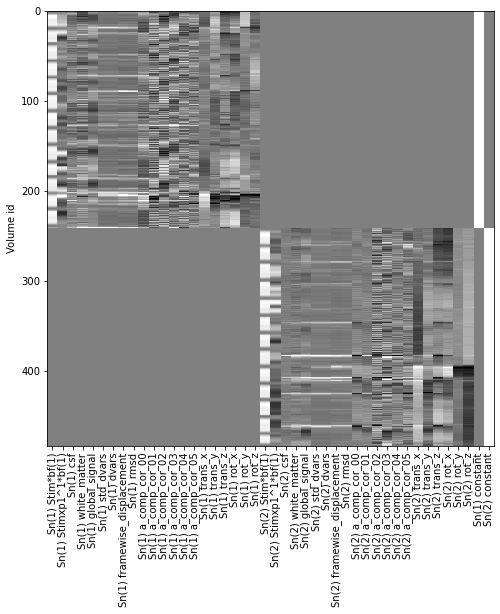

In [17]:
plot_designmat('/output/prob_pmod/1stLevel/sub-29/SPM.mat')

In [18]:
spmmat = load_spmmat('/output/prob_pmod/1stLevel/sub-29/SPM.mat')

In [19]:
spmmat['SPM'][0][0].xCon[0][0].name[0]

'pprob_p1'

In [20]:
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]
names

['Sn(1) Stim*bf(1)',
 'Sn(1) Stimxp1^1*bf(1)',
 'Sn(1) csf',
 'Sn(1) white_matter',
 'Sn(1) global_signal',
 'Sn(1) std_dvars',
 'Sn(1) dvars',
 'Sn(1) framewise_displacement',
 'Sn(1) rmsd',
 'Sn(1) a_comp_cor_00',
 'Sn(1) a_comp_cor_01',
 'Sn(1) a_comp_cor_02',
 'Sn(1) a_comp_cor_03',
 'Sn(1) a_comp_cor_04',
 'Sn(1) a_comp_cor_05',
 'Sn(1) trans_x',
 'Sn(1) trans_y',
 'Sn(1) trans_z',
 'Sn(1) rot_x',
 'Sn(1) rot_y',
 'Sn(1) rot_z',
 'Sn(2) Stim*bf(1)',
 'Sn(2) Stimxp1^1*bf(1)',
 'Sn(2) csf',
 'Sn(2) white_matter',
 'Sn(2) global_signal',
 'Sn(2) std_dvars',
 'Sn(2) dvars',
 'Sn(2) framewise_displacement',
 'Sn(2) rmsd',
 'Sn(2) a_comp_cor_00',
 'Sn(2) a_comp_cor_01',
 'Sn(2) a_comp_cor_02',
 'Sn(2) a_comp_cor_03',
 'Sn(2) a_comp_cor_04',
 'Sn(2) a_comp_cor_05',
 'Sn(2) trans_x',
 'Sn(2) trans_y',
 'Sn(2) trans_z',
 'Sn(2) rot_x',
 'Sn(2) rot_y',
 'Sn(2) rot_z',
 'Sn(1) constant',
 'Sn(2) constant']

In [21]:
cons = [i[0] for i in spmmat['SPM'][0][0].xCon[0][0].c]
np.nonzero(cons)

(array([ 1, 22]),)

In [22]:
len(cons)

44

### check contrast

In [23]:
con = '/output/prob_pmod/1stLevel/sub-29/spmT_0001.nii'

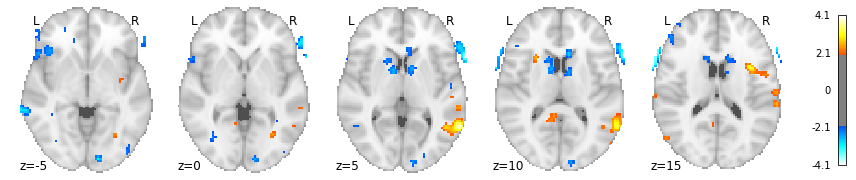

In [27]:
nilearn.plotting.plot_stat_map(con, threshold=2, display_mode='z', 
                               cut_coords=(-5,0,5,10,15))

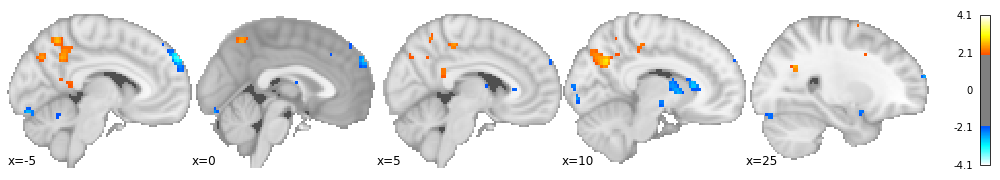

In [26]:
nilearn.plotting.plot_stat_map(con, threshold=2, display_mode='x', 
                               cut_coords=(-5,0,5,10,25))